<a href="https://colab.research.google.com/github/vcvcbot/LSTM/blob/main/brain_tumor_mri.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

# Set a random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Check PyTorch version and the device being used (GPU or CPU)
print(f"\nPyTorch Version: {torch.__version__}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")




PyTorch Version: 2.8.0+cu126
Using device: cuda


In [3]:
data_dir = '/content'
train_dir = os.path.join(data_dir, 'Training')
test_dir = os.path.join(data_dir, 'Testing')

# Define image transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomRotation(20),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [4]:
# Create PyTorch datasets
full_train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms['val'])

# Split the full training set into training and validation sets (80/20)
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_train_dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

class_names = full_train_dataset.classes
print(f'\nTraining set size: {len(train_dataset)}')
print(f'Validation set size: {len(val_dataset)}')
print(f'Test set size: {len(test_dataset)}')
print(f'Classes: {class_names}')



Training set size: 4569
Validation set size: 1143
Test set size: 1311
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


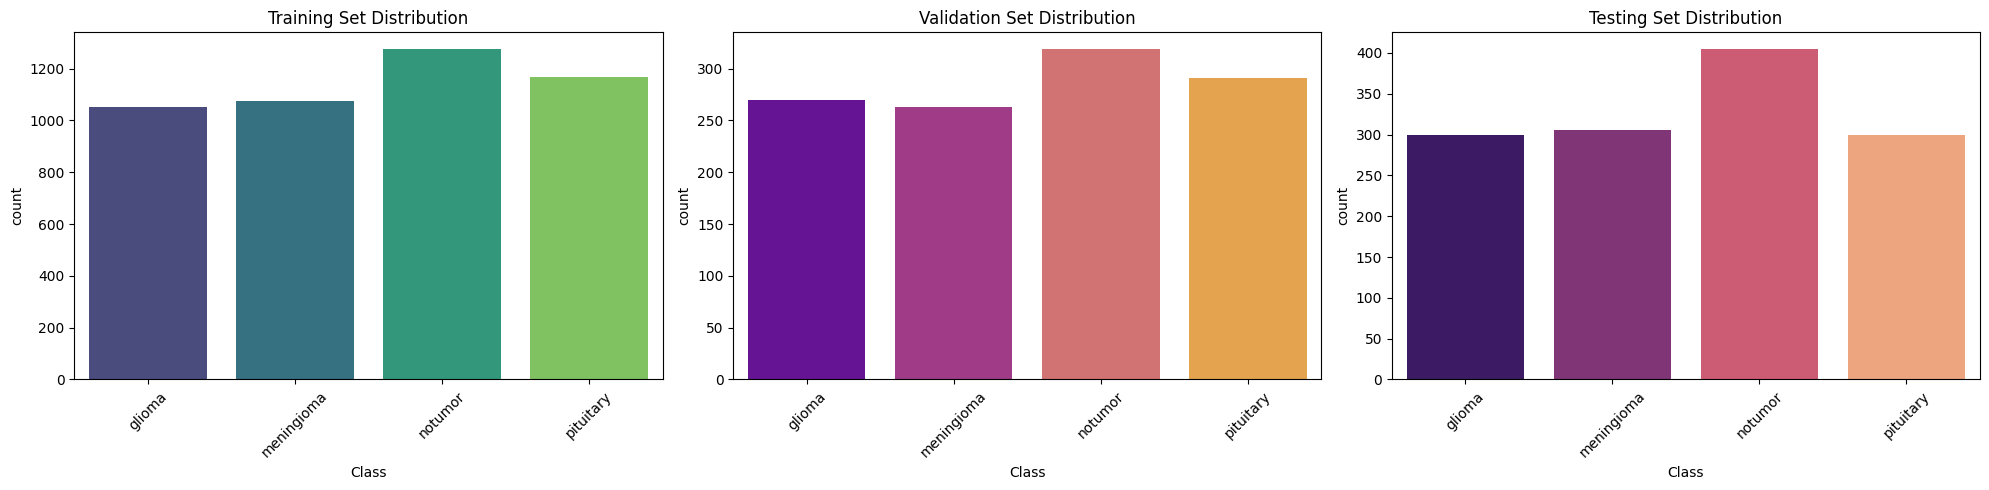

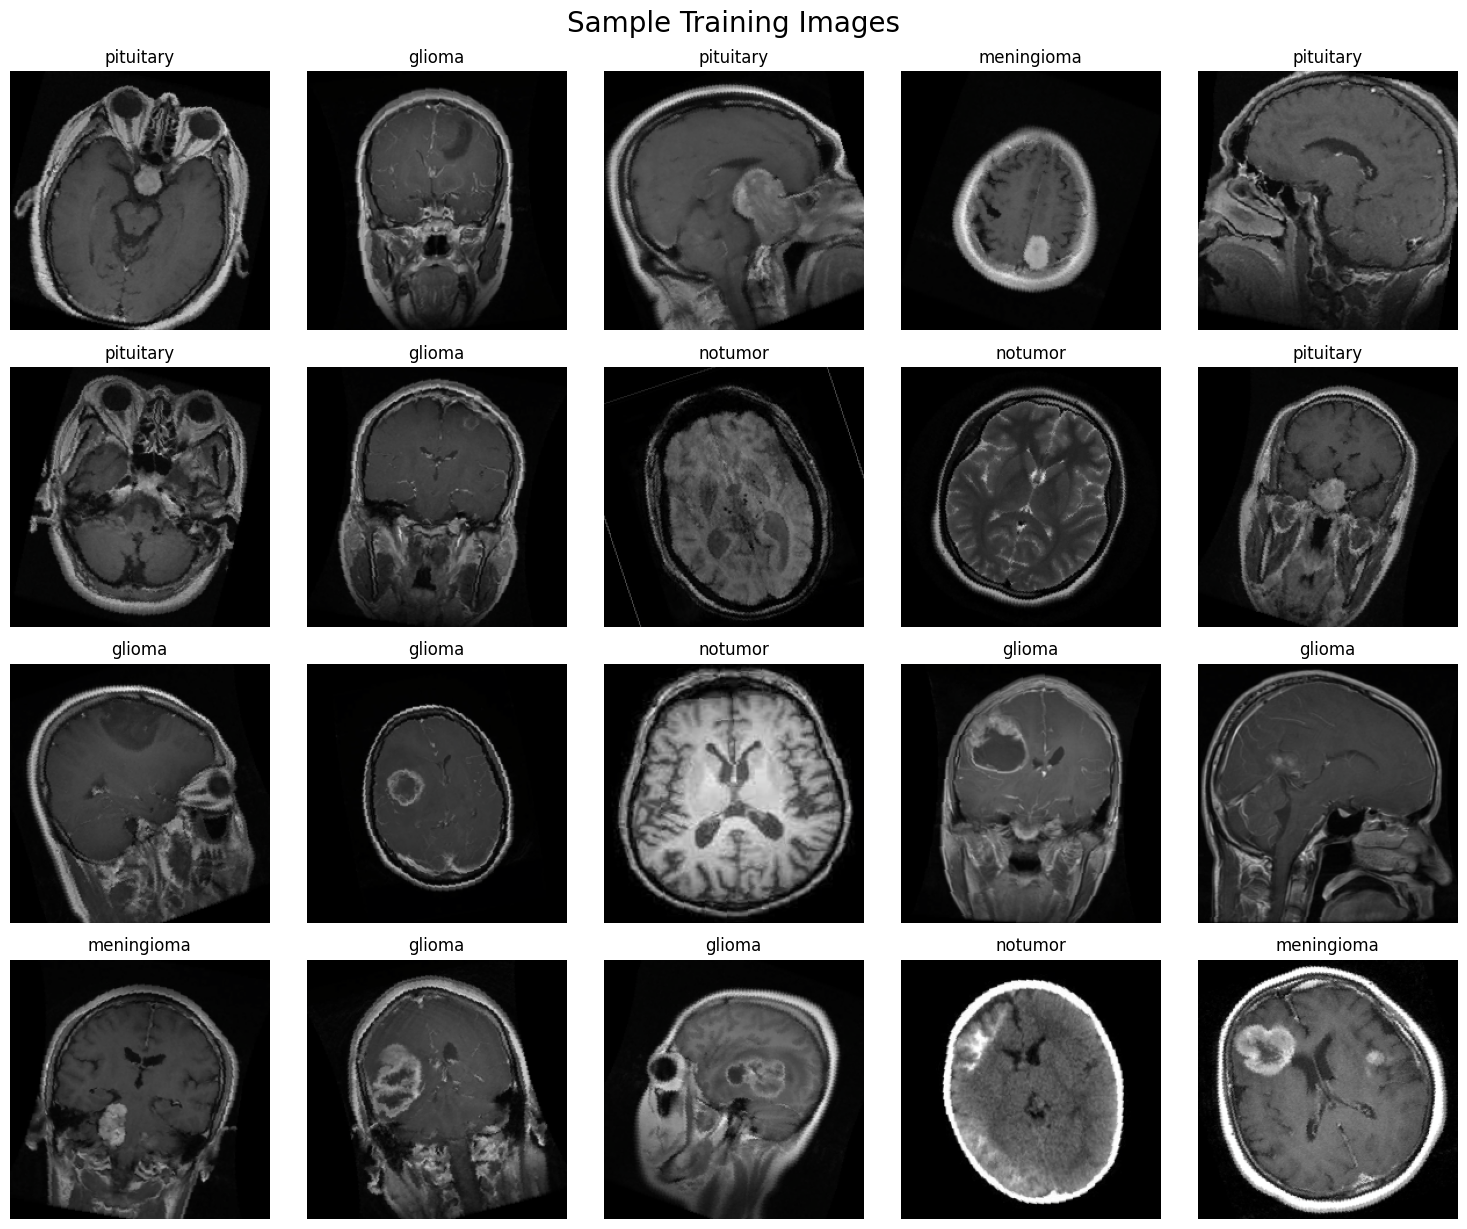

In [6]:
# Extract labels for distribution plots
y_train_labels = [full_train_dataset.targets[i] for i in train_dataset.indices]
y_val_labels = [full_train_dataset.targets[i] for i in val_dataset.indices]
y_test_labels = test_dataset.targets

# Plot the distribution of classes for each set
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
sns.countplot(x=y_train_labels, ax=ax1, palette='viridis')
ax1.set_title('Training Set Distribution')
ax1.set_xticklabels(class_names, rotation=45)
ax1.set_xlabel('Class')

sns.countplot(x=y_val_labels, ax=ax2, palette='plasma')
ax2.set_title('Validation Set Distribution')
ax2.set_xticklabels(class_names, rotation=45)
ax2.set_xlabel('Class')

sns.countplot(x=y_test_labels, ax=ax3, palette='magma')
ax3.set_title('Testing Set Distribution')
ax3.set_xticklabels(class_names, rotation=45)
ax3.set_xlabel('Class')

plt.tight_layout()
plt.show()

# Visualize some sample images from the training set
def imshow(ax, inp, title=None):
    """Imshow for Tensor on a specific Axes."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    # 使用 ax.imshow() 而不是 plt.imshow()
    ax.imshow(inp)
    if title is not None:
        # 使用 ax.set_title() 而不是 plt.title()
        ax.set_title(title)
    # 使用 ax.axis() 而不是 plt.axis()
    ax.axis('off')

# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Display images in a grid
fig, axes = plt.subplots(4, 5, figsize=(15, 12))
axes = axes.ravel()
for i in np.arange(0, 20):
    # 將 ax 傳遞給 imshow 函式
    ax = axes[i]
    imshow(ax, inputs[i], title=class_names[classes[i]])

plt.tight_layout()
plt.suptitle('Sample Training Images', fontsize=20, y=1.02)
plt.show()

In [7]:
def build_and_train_model(model_name, epochs=10):
    """
    Builds, trains, and returns a deep learning model and its training history.

    Args:
        model_name (str): The name of the model to build ('resnet50' or 'vgg16').
        epochs (int): The number of epochs to train for.

    Returns:
        tuple: (The trained model, a history dictionary with loss and accuracy).
    """
    print(f"\n--- Processing model: {model_name} ---")

    # Build the pre-trained model based on the name
    if model_name == "resnet50":
        model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, len(class_names))
    elif model_name == "vgg16":
        model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
        num_ftrs = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(num_ftrs, len(class_names))
    else:
        raise ValueError("Unsupported model name")

    model = model.to(device)

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    # Train the model
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()  # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass and optimize only if in training phase
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == "train":
                scheduler.step()

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
            history[f"{phase}_loss"].append(epoch_loss)
            history[f"{phase}_acc"].append(epoch_acc.item())

    return model, history

In [8]:
def evaluate_and_visualize(model, model_name, history):
    """
    Evaluates the model on the test set and visualizes its performance.

    Args:
        model (torch.nn.Module): The trained model.
        model_name (str): The name of the model.
        history (dict): The training history of the model.

    Returns:
        float: The overall accuracy of the model on the test set.
    """
    print(f"\n--- Evaluating model: {model_name} ---")

    model.eval()  # Set model to evaluate mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Print the classification report
    print(f"\nClassification Report for {model_name}:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Plot the confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # Plot the training history curves
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history["train_acc"], label="Training Accuracy")
    plt.plot(history["val_acc"], label="Validation Accuracy")
    plt.title(f"Accuracy Curve - {model_name}")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history["train_loss"], label="Training Loss")
    plt.plot(history["val_loss"], label="Validation Loss")
    plt.title(f"Loss Curve - {model_name}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return np.mean(np.array(all_preds) == np.array(all_labels))


--- Processing model: resnet50 ---
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 209MB/s]


Epoch 1/10
train Loss: 0.4625 Acc: 0.8319
val Loss: 1.2277 Acc: 0.6229
Epoch 2/10
train Loss: 0.2990 Acc: 0.8984
val Loss: 0.8701 Acc: 0.7052
Epoch 3/10
train Loss: 0.2479 Acc: 0.9127
val Loss: 0.1696 Acc: 0.9431
Epoch 4/10
train Loss: 0.2055 Acc: 0.9223
val Loss: 0.2911 Acc: 0.8828
Epoch 5/10
train Loss: 0.1939 Acc: 0.9346
val Loss: 0.2656 Acc: 0.9099
Epoch 6/10
train Loss: 0.1952 Acc: 0.9337
val Loss: 0.3399 Acc: 0.8828
Epoch 7/10
train Loss: 0.1430 Acc: 0.9525
val Loss: 0.1130 Acc: 0.9580
Epoch 8/10
train Loss: 0.0884 Acc: 0.9722
val Loss: 0.0739 Acc: 0.9816
Epoch 9/10
train Loss: 0.0644 Acc: 0.9772
val Loss: 0.0552 Acc: 0.9843
Epoch 10/10
train Loss: 0.0545 Acc: 0.9829
val Loss: 0.0603 Acc: 0.9825

--- Evaluating model: resnet50 ---

Classification Report for resnet50:
              precision    recall  f1-score   support

      glioma       0.99      0.98      0.99       300
  meningioma       0.98      0.96      0.97       306
     notumor       0.99      1.00      0.99       405

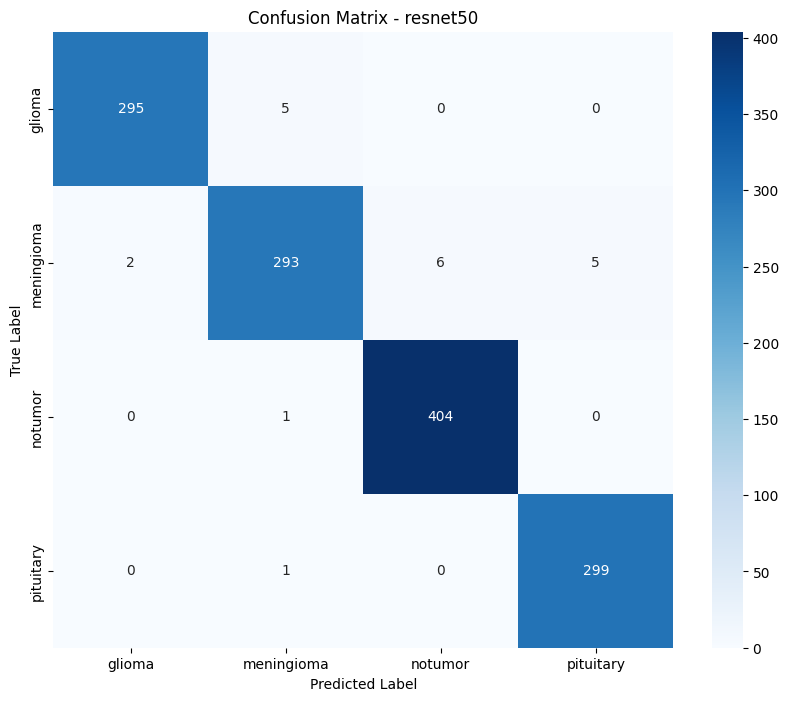

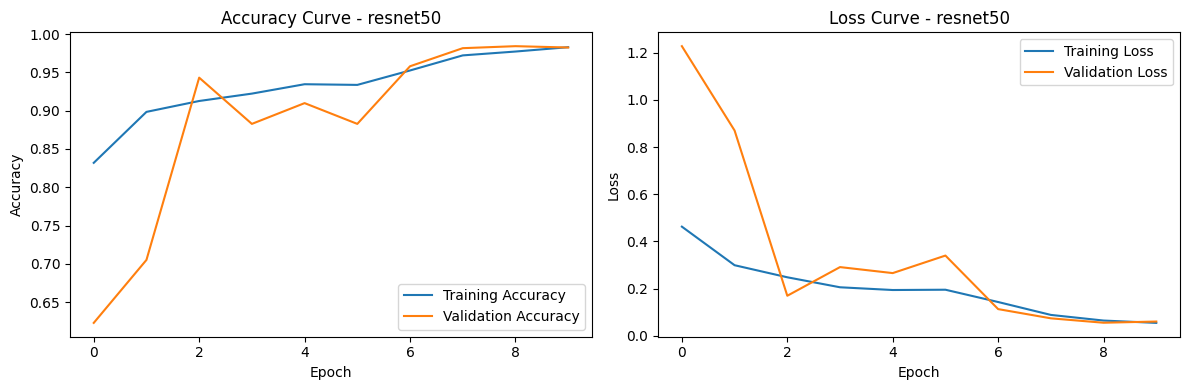


--- Processing model: vgg16 ---
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:02<00:00, 217MB/s]


Epoch 1/10
train Loss: 1.2676 Acc: 0.4058
val Loss: 0.7695 Acc: 0.6579
Epoch 2/10
train Loss: 0.8354 Acc: 0.6629
val Loss: 0.5557 Acc: 0.7970
Epoch 3/10
train Loss: 0.6086 Acc: 0.7772
val Loss: 0.4150 Acc: 0.8460
Epoch 4/10
train Loss: 0.4900 Acc: 0.8253
val Loss: 0.3862 Acc: 0.8521
Epoch 5/10
train Loss: 0.9237 Acc: 0.6295
val Loss: 0.8880 Acc: 0.6037
Epoch 6/10
train Loss: 0.6250 Acc: 0.7527
val Loss: 0.4086 Acc: 0.8320
Epoch 7/10
train Loss: 0.4624 Acc: 0.8293
val Loss: 0.9410 Acc: 0.7507
Epoch 8/10
train Loss: 0.3849 Acc: 0.8654
val Loss: 0.2939 Acc: 0.8959
Epoch 9/10
train Loss: 0.3028 Acc: 0.8906
val Loss: 0.2590 Acc: 0.8959
Epoch 10/10
train Loss: 0.2812 Acc: 0.8974
val Loss: 0.2402 Acc: 0.9108

--- Evaluating model: vgg16 ---

Classification Report for vgg16:
              precision    recall  f1-score   support

      glioma       0.95      0.76      0.85       300
  meningioma       0.71      0.67      0.69       306
     notumor       0.85      0.97      0.91       405
   pi

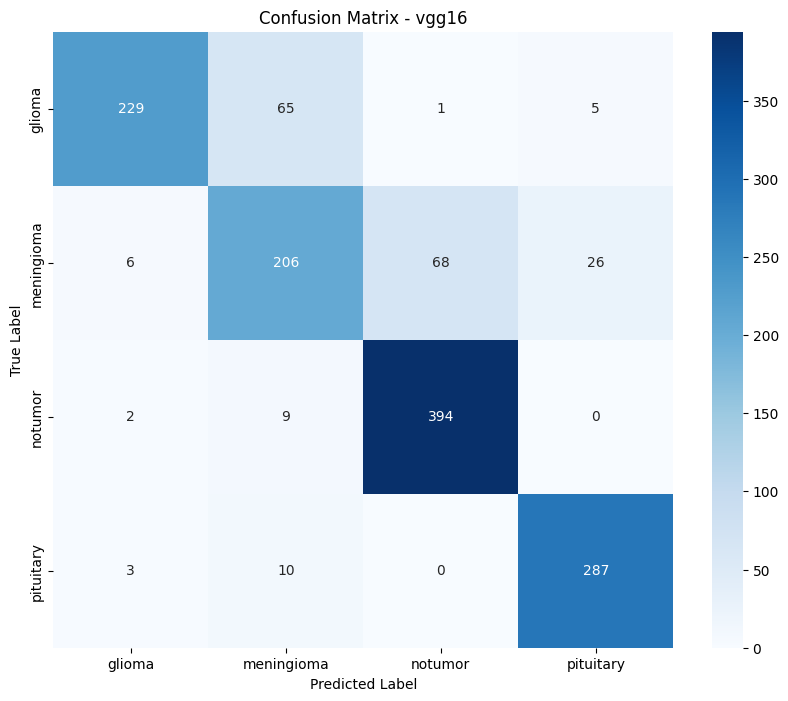

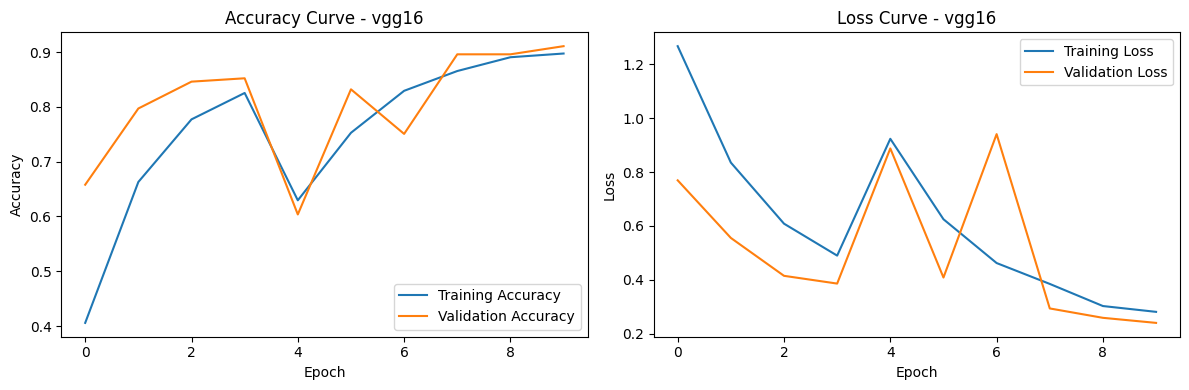


--- Model Comparison ---
resnet50 Test Set Accuracy: 98.47%
vgg16 Test Set Accuracy: 85.13%

The best model is: resnet50 with an accuracy of 98.47%


In [9]:
results = {}
models_to_run = ["resnet50", "vgg16"]

for model_name in models_to_run:
    # For a quick demonstration, we only train for 10 epochs.
    # You can increase the number of epochs for better performance.
    model, history = build_and_train_model(model_name, epochs=10)
    accuracy = evaluate_and_visualize(model, model_name, history)
    results[model_name] = accuracy

# Compare the final results
print("\n--- Model Comparison ---")
for model_name, acc in results.items():
    print(f"{model_name} Test Set Accuracy: {acc*100:.2f}%")

best_model_name = max(results, key=results.get)
print(f"\nThe best model is: {best_model_name} with an accuracy of {results[best_model_name]*100:.2f}%")

